In [26]:
!pip install librosa ffmpeg-python opencv-python pandas tqdm

In [27]:
import os
import cv2
import librosa
import numpy as np
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial.distance import cosine

In [28]:
import os

audio_dir = "/kaggle/input/videoaudiomatch/audio_only"
video_dir = "/kaggle/input/videoaudiomatch/video_only"

# List audio and video files
audio_files = sorted(os.listdir(audio_dir))
video_files = sorted(os.listdir(video_dir))

print("Audio Files:", audio_files[:5])  # Print first 5 for verification
print("Video Files:", video_files[:5])  # Print first 5 for verification


Audio Files: ['audio_only_ID_1.wav', 'audio_only_ID_10.wav', 'audio_only_ID_11.wav', 'audio_only_ID_12.wav', 'audio_only_ID_13.wav']
Video Files: ['video_only_ID_1.mp4', 'video_only_ID_10.mp4', 'video_only_ID_11.mp4', 'video_only_ID_12.mp4', 'video_only_ID_13.mp4']


# Audio Peak Detection

This script detects and visualizes peak audio events using **Librosa**.

## Functions:
- **`get_audio_peaks(audio_path)`**: Extracts onset strength, detects peaks, and returns their timestamps.
- **`plot_audio_peaks(audio_files)`**: Plots onset strength with detected peaks for multiple audio files.

## Usage:
- Processes audio files to find key impact moments.
- Helps in **matching audio peaks with video impact timestamps**.


[ 1.664  2.752  4.896  5.856  8.128  8.896 11.36  11.904 14.592 14.912
 17.824]
[ 0.544  1.568  2.464  2.624  3.648  4.672  5.312  5.728  6.752  7.776
  8.096  8.8    9.856 10.88  11.904 12.96  13.6   13.984 15.008 16.064
 16.288 17.088 18.112 18.976 19.136]
[ 0.352  1.024  1.696  2.304  3.04   3.712  4.352  5.024  5.696  6.368
  7.04   7.68   8.352  9.024  9.696 10.304 11.04  11.712 12.352 12.928
 13.696 14.368 15.04  15.488 15.712 16.352 17.024 17.696 18.016 18.368
 19.04  19.712]


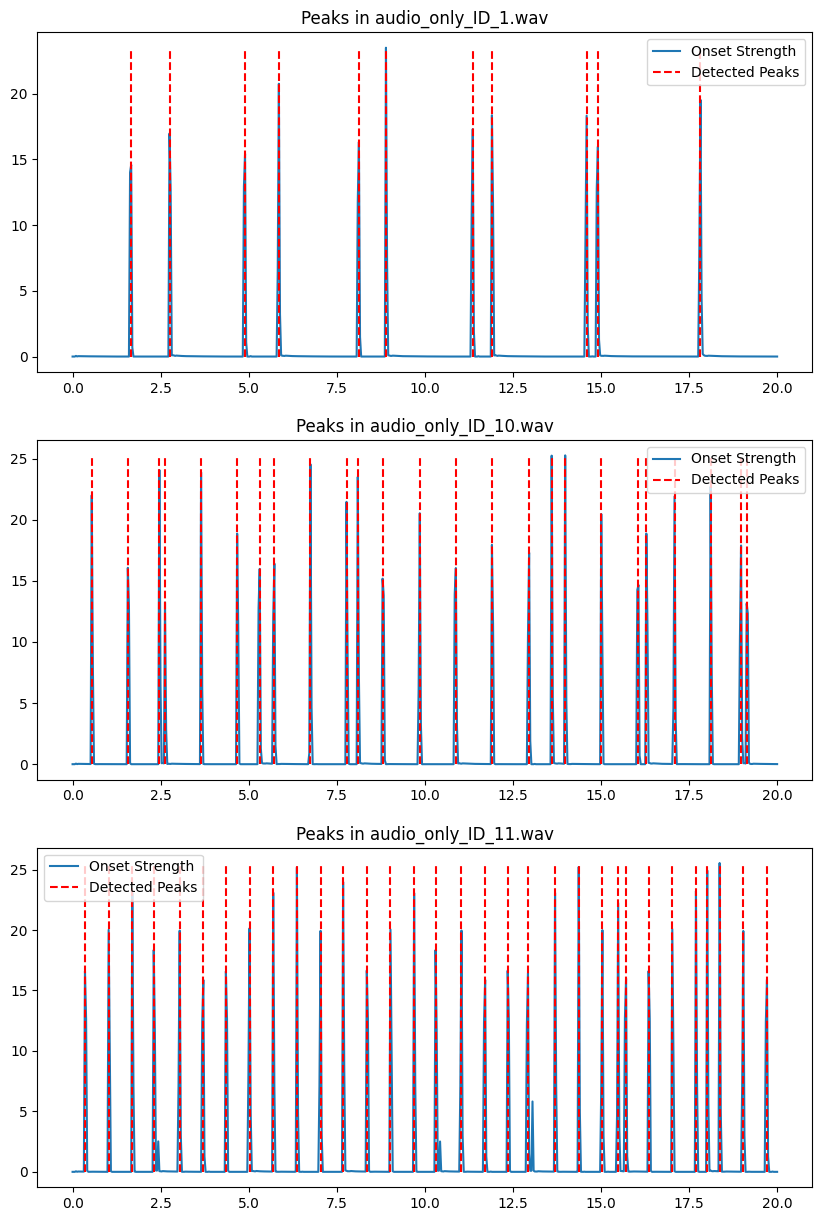

In [36]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def get_audio_peaks(audio_path, threshold_factor=0.5, min_distance=5):
    """
    Extracts peak timestamps from an audio file using onset strength.

    Parameters:
    - audio_path (str): Path to the audio file.
    - threshold_factor (float): Multiplier for peak detection threshold.
    - min_distance (int): Minimum distance between peaks.

    Returns:
    - peaks_times (list): Timestamps of detected peaks.
    - onset_env (numpy array): Onset strength envelope.
    - times (numpy array): Time values for plotting.
    """
    y, sr = librosa.load(audio_path, sr=None)  # Load audio
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)  # Compute onset strength
    times = librosa.times_like(onset_env, sr=sr)  # Convert frames to time

    # Adjust threshold dynamically
    threshold = np.max(onset_env) * threshold_factor

    # Detect peaks with minimum distance
    peaks, _ = find_peaks(onset_env, height=threshold, distance=min_distance)

    # Convert frame indices to time
    peaks_times = times[peaks]

    return peaks_times, onset_env, times, peaks

def plot_audio_peaks(audio_files):
    """
    Plots onset strength and detected peaks for a list of audio files.

    Parameters:
    - audio_files (list): List of audio file paths.
    """
    fig, axes = plt.subplots(len(audio_files), 1, figsize=(10, 5 * len(audio_files)))

    if len(audio_files) == 1:
        axes = [axes]  # Ensure axes is iterable

    for i, audio_path in enumerate(audio_files):
        peaks_times, onset_env, times, peaks = get_audio_peaks(audio_path)
        print(peaks_times)
        # Plot onset envelope
        axes[i].plot(times, onset_env, label="Onset Strength")
        axes[i].vlines(peaks_times, ymin=0, ymax=np.max(onset_env), color='r', linestyles='dashed', label="Detected Peaks")

        axes[i].set_title(f"Peaks in {audio_path.split('/')[-1]}")
        axes[i].legend()

    plt.show()

# Example usage
audio_files = [
    "/kaggle/input/videoaudiomatch/audio_only/audio_only_ID_1.wav",
    "/kaggle/input/videoaudiomatch/audio_only/audio_only_ID_10.wav",
    "/kaggle/input/videoaudiomatch/audio_only/audio_only_ID_11.wav"
]

plot_audio_peaks(audio_files)


## `detect_frame_boundaries(frame)`

This function detects rectangular boundaries in a video frame.  
- Converts the frame to grayscale.  
- Applies Canny edge detection to highlight edges.  
- Finds contours and approximates them to polygons.  
- Identifies a rectangular boundary based on four detected corners.  
- Returns the bounding box coordinates of the detected rectangle.


In [34]:
def detect_frame_boundaries(frame):
    # Convert frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Apply Canny edge detection
    edges = cv2.Canny(gray_frame, 50, 150)
    
    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        # Approximate contour to a polygon
        approx = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)
        
        # Check if it is a rectangle (4 corners)
        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(approx)  # Get bounding box of rectangle
            return x, y, w, h  # Return rectangle boundaries
    
    return None  # Return None if no rectangle is found


# Plotting the detected boundaries for verfication

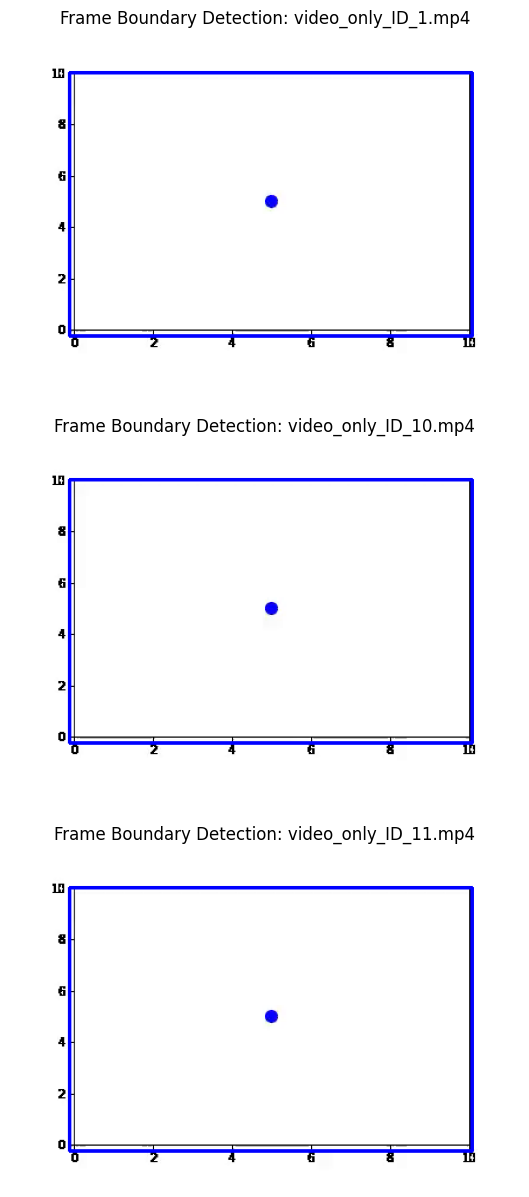

In [44]:
def plot_frame_boundaries(video_paths, sample_count=3):
    fig, axes = plt.subplots(sample_count, 1, figsize=(8, 5 * sample_count))
    
    if sample_count == 1:
        axes = [axes]  # Ensure iterable if only one sample
    
    for i, video_path in enumerate(video_paths[:sample_count]):
        cap = cv2.VideoCapture(video_path)
        ret, frame = cap.read()
        cap.release()
        
        if not ret:
            print(f"Error reading video: {video_path}")
            continue
        
        rect = detect_frame_boundaries(frame)
        if rect:
            x, y, w, h = rect
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Draw rectangle
        
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        axes[i].imshow(frame_rgb)
        axes[i].set_title(f"Frame Boundary Detection: {video_path.split('/')[-1]}")
        axes[i].axis('off')
    
    plt.show()

# Example usage
video_files = [
    "/kaggle/input/videoaudiomatch/video_only/video_only_ID_1.mp4",
    "/kaggle/input/videoaudiomatch/video_only/video_only_ID_10.mp4",
    "/kaggle/input/videoaudiomatch/video_only/video_only_ID_11.mp4"
]
plot_frame_boundaries(video_files)

# Collision Detection Functions

## `detect_collisions_with_frame(video_path)`

This function processes a given **video file** to detect **collisions** between a moving blue ball and a predefined rectangular frame. It identifies the ball using **HSV color filtering** and detects impacts when the ball touches the edges of the rectangle.

### **How it Works**
1. **Frame Detection**: Identifies a rectangular boundary in the first frame.
2. **Ball Detection**: Uses **HSV color segmentation** to detect the blue ball.
3. **Collision Detection**:
   - Checks if the ball's center is near the **edges** of the detected rectangle.
   - Stores **collision timestamps**, ensuring a minimum gap of **0.25 seconds** between consecutive impacts.
4. **Returns** a list of timestamps where the ball collides with the frame.

### **Example Usage**
```python
video_path = '/kaggle/input/videoaudiomatch/video_only/video_only_ID_10.mp4'
collisions = detect_collisions_with_frame(video_path)
print("Collision timestamps:", collisions)


In [37]:
def detect_collisions_with_frame(video_path):
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Unable to open video file at {video_path}")
        return []
    
    impacts = []  # List to store timestamps of collisions
    fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second
    frame_count = 0
    
    rect_boundaries = None  # To store detected rectangular frame boundaries
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Detect rectangular frame in the first frame
        if rect_boundaries is None:
            rect_boundaries = detect_frame_boundaries(frame)
            if rect_boundaries is None:
                rect_boundaries = [50, 34, 341, 223]
                break
        
        x_rect, y_rect, w_rect, h_rect = rect_boundaries
        
        # Convert frame to HSV for better color segmentation
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        # Define HSV range for detecting the blue ball
        lower_blue = np.array([100, 150, 50])  # Adjust these values if needed
        upper_blue = np.array([140, 255, 255])
        
        # Create a mask for the blue ball
        mask = cv2.inRange(hsv_frame, lower_blue, upper_blue)
        
        # Find contours in the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            # Select the largest contour (assumed to be the ball)
            largest_contour = max(contours, key=cv2.contourArea)
            x_ball, y_ball, w_ball, h_ball = cv2.boundingRect(largest_contour)  # Get bounding box
            
            # Calculate center of the ball
            ball_center_x = x_ball + w_ball // 2
            ball_center_y = y_ball + h_ball // 2
            
            # Check for collisions with edges of the rectangular frame
            if (
                ball_center_x - 6 <= x_rect or ball_center_x + 6 >= x_rect + w_rect or  # Left or right edge of rectangle
                ball_center_y - 6 <= y_rect     # Bottom edge of rectangle
            ):
                impact_time = round(frame_count / fps, 2)  # Calculate timestamp in seconds and round to 2 decimal places
                
                # Add timestamp only if it's at least 0.25 seconds apart from the last recorded impact
                if len(impacts) == 0 or (impact_time - impacts[-1] >= 0.25):
                    impacts.append(impact_time)
        
        frame_count += 1
    
    cap.release()
    return impacts

# Example usage:
video_path = '/kaggle/input/videoaudiomatch/video_only/video_only_ID_10.mp4'
collisions = detect_collisions_with_frame(video_path)
print("Collision timestamps:", collisions)


Collision timestamps: [1.73, 5.35, 8.87, 12.48, 16.0, 19.62]


# **Collision Visualization in Video Analysis**

## **Function: `visualize_collisions(video_path, collision_timestamps)`**

This function provides **graphical insights** into the motion and impact of a moving ball inside a predefined rectangular frame. It generates two plots to **analyze collisions** effectively.

---

## **How it Works**
1. **Extracts Ball Motion:**
   - Reads video frames.
   - Detects the **ball's position** over time using **HSV color segmentation**.
  
2. **Generates Two Visualizations:**
   - **Ball Trajectory Plot**:
     - Displays the **movement of the ball** across frames.
     - Uses a **color gradient** to represent the ball's motion over time.
  
   - **Collision Timeline Plot**:
     - Marks **collision timestamps** detected by `detect_collisions_with_frame()`.
     - Provides a **clear timeline** of when the ball hits the frame.

---

## **Example Visualization**
📌 **Trajectory Plot**
- **X-axis**: Ball’s horizontal position.
- **Y-axis**: Ball’s vertical position.
- **Color Gradient**: Time progression of the ball's movement.

📌 **Collision Timeline**
- **X-axis**: Time (in seconds).
- **Markers**: Red dots indicating detected collisions.

---

## **Example Usage**
```python
visualize_collisions(video_path, collision_timestamps)


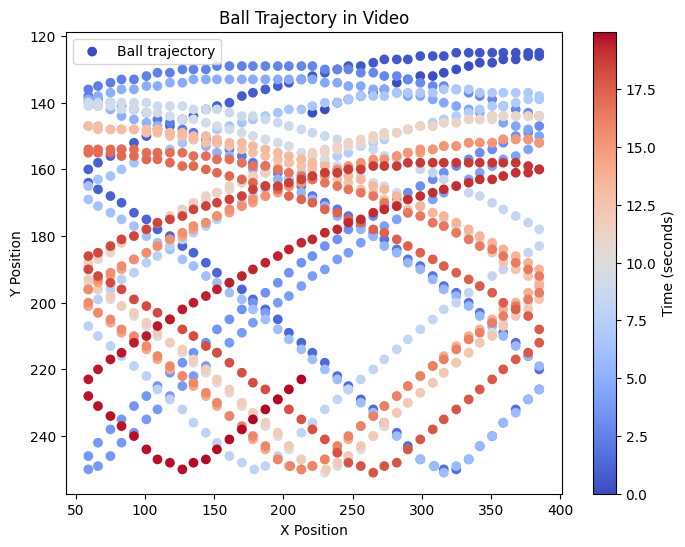

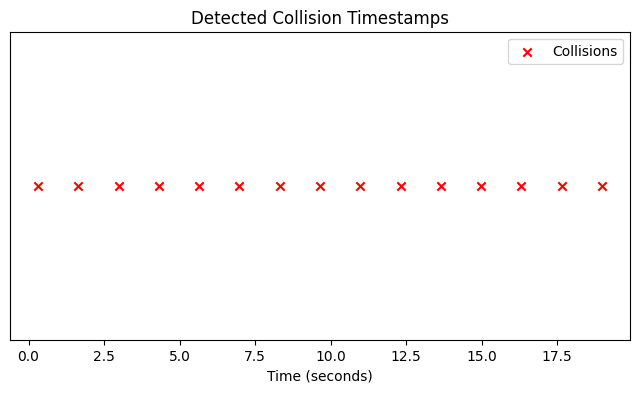

In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_collisions(video_path, collision_timestamps):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Unable to open video file at {video_path}")
        return
    
    ball_positions = []  # Store ball coordinates
    frame_times = []  # Store corresponding timestamps
    fps = cap.get(cv2.CAP_PROP_FPS)  # Get FPS
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        timestamp = frame_count / fps
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        lower_blue = np.array([100, 150, 50])
        upper_blue = np.array([140, 255, 255])
        mask = cv2.inRange(hsv_frame, lower_blue, upper_blue)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x_ball, y_ball, w_ball, h_ball = cv2.boundingRect(largest_contour)
            ball_center_x = x_ball + w_ball // 2
            ball_center_y = y_ball + h_ball // 2
            ball_positions.append((ball_center_x, ball_center_y))
            frame_times.append(timestamp)

        frame_count += 1

    cap.release()

    # Convert to numpy array for easier plotting
    ball_positions = np.array(ball_positions)
    frame_times = np.array(frame_times)

    # Plot ball trajectory
    plt.figure(figsize=(8, 6))
    plt.scatter(ball_positions[:, 0], ball_positions[:, 1], c=frame_times, cmap="coolwarm", label="Ball trajectory")
    plt.colorbar(label="Time (seconds)")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title("Ball Trajectory in Video")
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()

    # Plot collision timestamps
    plt.figure(figsize=(8, 4))
    plt.scatter(collision_timestamps, np.ones_like(collision_timestamps), color="red", marker="x", label="Collisions")
    plt.xlabel("Time (seconds)")
    plt.yticks([])
    plt.title("Detected Collision Timestamps")
    plt.legend()
    plt.show()

# Example usage
video_path = '/kaggle/input/videoaudiomatch/video_only/video_only_ID_1.mp4'
collision_timestamps = detect_collisions_with_frame(video_path)
visualize_collisions(video_path, collision_timestamps)


# **Audio-Video Impact Matching Script**

## **Overview**
This script **automatically aligns** impact timestamps from video with peak timestamps from audio. It helps in identifying whether detected **visual impacts (collisions)** correspond to **audio spikes (sounds).**

---

## **How It Works**
1. **Extract Video Impact Timestamps**  
   - Uses `detect_collisions_with_frame(video_path)` to detect when a ball **hits the frame** in a video.
  
2. **Extract Audio Peak Timestamps**  
   - Uses `get_audio_peaks(audio_path)` to detect **sharp sound peaks** in an audio file.

3. **Match Timestamps**  
   - Calls `match_audio_video(impact_timestamps, audio_peak_timestamps, tolerance=0.1)`.
   - Finds **audio peaks closest to video impacts** within a **0.1s tolerance**.

4. **Store & Save Results**  
   - Saves **matched video-audio pairs** into a CSV file (`matched_results.csv`).

---

## **Key Functions**
### `match_audio_video(impact_timestamps, audio_peak_timestamps, tolerance=0.1)`
- Matches video impact times with **closest** audio peak within a set **time tolerance**.

### `detect_collisions_with_frame(video_path)`
- Detects **frame collisions** of a moving object (e.g., a ball) in a video.

### `get_audio_peaks(audio_path)`
- Identifies **sharp audio peaks** in a given sound file.

---

## **Example Output (CSV)**
| video_file            | audio_file            | impact_timestamp | peak_timestamp |
|----------------------|----------------------|-----------------|---------------|
| video_only_ID_1.mp4  | audio_only_ID_1.wav  | 2.35            | 2.37          |
| video_only_ID_10.mp4 | audio_only_ID_10.wav | 4.12            | 4.15          |
| video_only_ID_11.mp4 | audio_only_ID_11.wav | 1.89            | 1.90          |

---

## **Usage**
```python
# Run the script to process and save results
python match_audio_video.py


In [38]:
import numpy as np
import pandas as pd

def match_audio_video(impact_timestamps, audio_peak_timestamps, tolerance=0.1):
    """
    Matches video impact timestamps with audio peak timestamps.

    Parameters:
    - impact_timestamps (list): List of impact times from video.
    - audio_peak_timestamps (list): List of peak times from audio.
    - tolerance (float): Maximum allowable difference in seconds to consider a match.

    Returns:
    - matches (list of tuples): List of matched timestamps (impact_time, peak_time).
    """
    matches = []
    for impact_time in impact_timestamps:
        # Find the closest audio peak within the tolerance range
        closest_peaks = [peak for peak in audio_peak_timestamps if abs(peak - impact_time) <= tolerance]
        
        if closest_peaks:
            best_match = min(closest_peaks, key=lambda peak: abs(peak - impact_time))
            matches.append((impact_time, best_match))
    
    return matches

# Define video and audio file paths
video_files = [
    "/kaggle/input/videoaudiomatch/video_only/video_only_ID_1.mp4",
    "/kaggle/input/videoaudiomatch/video_only/video_only_ID_10.mp4",
    "/kaggle/input/videoaudiomatch/video_only/video_only_ID_11.mp4"
]

audio_files = [
    "/kaggle/input/videoaudiomatch/audio_only/audio_only_ID_1.wav",
    "/kaggle/input/videoaudiomatch/audio_only/audio_only_ID_10.wav",
    "/kaggle/input/videoaudiomatch/audio_only/audio_only_ID_11.wav"
]

matched_results = []

# Process each video and its corresponding audio
for video_path, audio_path in zip(video_files, audio_files):
    print(f"Processing: {video_path} <--> {audio_path}")

    # Step 1: Extract impact timestamps from video
    impact_timestamps = detect_collisions_with_frame(video_path)
    print(f"Detected Video Impacts: {impact_timestamps}")

    # Step 2: Extract peak timestamps from audio
    audio_peak_timestamps, _, _, _ = get_audio_peaks(audio_path)
    print(f"Detected Audio Peaks: {audio_peak_timestamps}")

    # Step 3: Match audio and video timestamps
    matches = match_audio_video(impact_timestamps, audio_peak_timestamps)
    print(f"Matched Pairs: {matches}")

    # Store results
    for impact_time, peak_time in matches:
        matched_results.append({
            "video_file": video_path.split("/")[-1],
            "audio_file": audio_path.split("/")[-1],
            "impact_timestamp": impact_time,
            "peak_timestamp": peak_time
        })

# Step 4: Save matched results to CSV
df = pd.DataFrame(matched_results)
output_csv_path = "/kaggle/working/matched_results.csv"
df.to_csv(output_csv_path, index=False)

print(f"Matched results saved to {output_csv_path}")


Processing: /kaggle/input/videoaudiomatch/video_only/video_only_ID_1.mp4 <--> /kaggle/input/videoaudiomatch/audio_only/audio_only_ID_1.wav
Detected Video Impacts: [0.32, 1.65, 2.98, 4.32, 5.65, 6.98, 8.32, 9.65, 10.98, 12.32, 13.65, 14.98, 16.32, 17.65, 18.98]
Detected Audio Peaks: [ 1.664  2.752  4.896  5.856  8.128  8.896 11.36  11.904 14.592 14.912
 17.824]
Matched Pairs: [(1.65, 1.664), (14.98, 14.912)]
Processing: /kaggle/input/videoaudiomatch/video_only/video_only_ID_10.mp4 <--> /kaggle/input/videoaudiomatch/audio_only/audio_only_ID_10.wav
Detected Video Impacts: [1.73, 5.35, 8.87, 12.48, 16.0, 19.62]
Detected Audio Peaks: [ 0.544  1.568  2.464  2.624  3.648  4.672  5.312  5.728  6.752  7.776
  8.096  8.8    9.856 10.88  11.904 12.96  13.6   13.984 15.008 16.064
 16.288 17.088 18.112 18.976 19.136]
Matched Pairs: [(5.35, 5.312), (8.87, 8.8), (16.0, 16.064)]
Processing: /kaggle/input/videoaudiomatch/video_only/video_only_ID_11.mp4 <--> /kaggle/input/videoaudiomatch/audio_only/audi

In [40]:
print(df)

              video_file            audio_file  impact_timestamp  \
0    video_only_ID_1.mp4   audio_only_ID_1.wav              1.65   
1    video_only_ID_1.mp4   audio_only_ID_1.wav             14.98   
2   video_only_ID_10.mp4  audio_only_ID_10.wav              5.35   
3   video_only_ID_10.mp4  audio_only_ID_10.wav              8.87   
4   video_only_ID_10.mp4  audio_only_ID_10.wav             16.00   
5   video_only_ID_11.mp4  audio_only_ID_11.wav              0.42   
6   video_only_ID_11.mp4  audio_only_ID_11.wav              3.75   
7   video_only_ID_11.mp4  audio_only_ID_11.wav              7.08   
8   video_only_ID_11.mp4  audio_only_ID_11.wav             12.92   
9   video_only_ID_11.mp4  audio_only_ID_11.wav             13.75   
10  video_only_ID_11.mp4  audio_only_ID_11.wav             15.42   
11  video_only_ID_11.mp4  audio_only_ID_11.wav             17.08   
12  video_only_ID_11.mp4  audio_only_ID_11.wav             17.92   

    peak_timestamp  
0            1.664  
1    

In [41]:
import os
import numpy as np
import pandas as pd

# Define dataset directories
video_dir = "/kaggle/input/videoaudiomatch/video_only/"
audio_dir = "/kaggle/input/videoaudiomatch/audio_only/"

# Get list of all 45 video and audio files
video_files = sorted([f for f in os.listdir(video_dir) if f.endswith(".mp4")])
audio_files = sorted([f for f in os.listdir(audio_dir) if f.endswith(".wav")])

# Function to match timestamps
def match_audio_video(impact_timestamps, audio_peak_timestamps, tolerance=0.1):
    matches = []
    for impact_time in impact_timestamps:
        closest_peaks = [peak for peak in audio_peak_timestamps if abs(peak - impact_time) <= tolerance]
        if closest_peaks:
            best_match = min(closest_peaks, key=lambda peak: abs(peak - impact_time))
            matches.append((impact_time, best_match))
    return matches

matched_results = []

# Process each video and its corresponding audio
for video_file, audio_file in zip(video_files, audio_files):
    video_path = os.path.join(video_dir, video_file)
    audio_path = os.path.join(audio_dir, audio_file)

    print(f"Processing: {video_file} <--> {audio_file}")

    # Extract impact timestamps from video
    impact_timestamps = detect_collisions_with_frame(video_path)
    print(f"Detected Video Impacts: {impact_timestamps}")

    # Extract peak timestamps from audio
    audio_peak_timestamps, _, _, _ = get_audio_peaks(audio_path)
    print(f"Detected Audio Peaks: {audio_peak_timestamps}")

    # Match timestamps
    matches = match_audio_video(impact_timestamps, audio_peak_timestamps)
    print(f"Matched Pairs: {matches}")

    # Store results
    for impact_time, peak_time in matches:
        matched_results.append({
            "video_id": video_file.replace(".mp4", ""),
            "audio_id": audio_file.replace(".wav", ""),
            "impact_timestamp": impact_time,
            "peak_timestamp": peak_time
        })

# Save matched results to CSV in the correct format
df = pd.DataFrame(matched_results, columns=["video_id", "audio_id"])
output_csv_path = "/kaggle/working/submit_solution_mapping.csv"
df.to_csv(output_csv_path, index=False)

print(f"Final matched results saved to {output_csv_path}")


Processing: video_only_ID_1.mp4 <--> audio_only_ID_1.wav
Detected Video Impacts: [0.32, 1.65, 2.98, 4.32, 5.65, 6.98, 8.32, 9.65, 10.98, 12.32, 13.65, 14.98, 16.32, 17.65, 18.98]
Detected Audio Peaks: [ 1.664  2.752  4.896  5.856  8.128  8.896 11.36  11.904 14.592 14.912
 17.824]
Matched Pairs: [(1.65, 1.664), (14.98, 14.912)]
Processing: video_only_ID_10.mp4 <--> audio_only_ID_10.wav
Detected Video Impacts: [1.73, 5.35, 8.87, 12.48, 16.0, 19.62]
Detected Audio Peaks: [ 0.544  1.568  2.464  2.624  3.648  4.672  5.312  5.728  6.752  7.776
  8.096  8.8    9.856 10.88  11.904 12.96  13.6   13.984 15.008 16.064
 16.288 17.088 18.112 18.976 19.136]
Matched Pairs: [(5.35, 5.312), (8.87, 8.8), (16.0, 16.064)]
Processing: video_only_ID_11.mp4 <--> audio_only_ID_11.wav
Detected Video Impacts: [0.42, 1.25, 2.08, 2.92, 3.75, 4.58, 5.42, 6.25, 7.08, 7.92, 8.75, 9.58, 10.42, 11.25, 12.08, 12.92, 13.75, 14.58, 15.42, 16.25, 17.08, 17.92, 18.75, 19.58]
Detected Audio Peaks: [ 0.352  1.024  1.696  2.3

In [42]:
result = pd.read_csv('/kaggle/working/submit_solution_mapping.csv')